In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.stats import poisson
import datetime as dt
from betting_functions import *
from unidecode import unidecode
plt.rcParams['figure.figsize'] = [13, 7]
pd.set_option("display.precision", 3)


In [2]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.min_rows', 20)

In [3]:
opp_stats = pd.read_csv('opponent_stats.csv',index_col=0)
schedule = pd.read_csv('schedule.csv',index_col=0)
pdata = pd.read_csv('pdata.csv')
data = pd.read_csv('data_test.csv')
KM_vals = pd.read_csv('KM_vals.csv',index_col=0)

line_list = []

for m in range(3,5):
    for i in range(1, 32):
        file_name = f"Lines/lines{m}_{i}"
        yest_file = f"Lines/lines{m}_{i-1}"
        try:
            # Use globals() to dynamically set the variable name
            globals()[f"lines{m}_{i}"] = pd.read_csv(file_name, index_col=0)
            pp_today = pd.read_csv(file_name, index_col=0)
            pp_yesterday = pd.read_csv(yest_file, index_col=0)
        except FileNotFoundError:
            notfound = file_name
           

In [4]:
data = pd.concat((pdata,data))
data= data.reset_index(drop=True)
data.sample(3)

,player,G,date,series,team,H/A,opp,G#,W/L,GS,...,BLK,TOV,PF,PTS,GmSc,+/-,pos,KM,age,PTS_miss
28153,Daishen Nix,55,2023-04-02,NaN,HOU,1,LAL,NaN,-25,0,...,0,0,1,0,-1.5,-8.0,PG,9,21-048,96.085
7938,Julius Randle,60,2023-02-15,NaN,NYK,0,ATL,NaN,21,1,...,0,3,4,25,16.2,20.0,PF,10,28-078,84.478
2905,Torrey Craig,12,2020-09-11,WCS,DEN,0,LAC,5.0,6,0,...,0,0,1,4,5.3,-8.0,SF,15,NaN,NaN


In [5]:
data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d")
data['rest'] = data.groupby('player')['date'].diff().dt.days
player_names = data['player'].unique()


In [6]:
data.loc[data.player=='Stephen Curry'].sort_values(by='date')

,player,G,date,series,team,H/A,opp,G#,W/L,GS,...,TOV,PF,PTS,GmSc,+/-,pos,KM,age,PTS_miss,rest
595,Stephen Curry,1,2013-04-20,WC1,GSW,0,DEN,1.0,-2,1,...,5,2,19,11.5,8.0,PG,15,NaN,NaN,NaN
596,Stephen Curry,2,2013-04-23,WC1,GSW,0,DEN,2.0,14,1,...,1,4,30,30.1,15.0,PG,15,NaN,NaN,3.0
597,Stephen Curry,3,2013-04-26,WC1,GSW,1,DEN,3.0,2,1,...,3,4,29,27.2,13.0,PG,15,NaN,NaN,3.0
598,Stephen Curry,4,2013-04-28,WC1,GSW,1,DEN,4.0,14,1,...,2,4,31,30.0,21.0,PG,15,NaN,NaN,2.0
599,Stephen Curry,5,2013-04-30,WC1,GSW,0,DEN,5.0,-7,1,...,2,5,15,8.4,-3.0,PG,15,NaN,NaN,2.0
600,Stephen Curry,6,2013-05-02,WC1,GSW,1,DEN,6.0,4,1,...,7,3,22,15.6,-2.0,PG,15,NaN,NaN,2.0
601,Stephen Curry,7,2013-05-06,WCS,GSW,0,SAS,1.0,-2,1,...,6,3,44,30.4,-2.0,PG,15,NaN,NaN,4.0
602,Stephen Curry,8,2013-05-08,WCS,GSW,0,SAS,2.0,9,1,...,2,2,22,11.8,16.0,PG,15,NaN,NaN,2.0
603,Stephen Curry,9,2013-05-10,WCS,GSW,1,SAS,3.0,-10,1,...,3,3,16,10.1,1.0,PG,15,NaN,NaN,2.0
604,Stephen Curry,10,2013-05-12,WCS,GSW,1,SAS,4.0,10,1,...,2,2,22,16.9,23.0,PG,15,NaN,NaN,2.0


In [7]:
data = data.fillna(5)
data

,player,G,date,series,team,H/A,opp,G#,W/L,GS,...,TOV,PF,PTS,GmSc,+/-,pos,KM,age,PTS_miss,rest
0,Devin Booker,1,2021-05-23,WC1,PHX,1,LAL,1.0,9,1,...,6,4,34,22.1,9.0,SG,15,5,5.000,5.0
1,Devin Booker,2,2021-05-25,WC1,PHX,1,LAL,2.0,-7,1,...,4,3,31,19.1,-16.0,SG,15,5,5.000,2.0
2,Devin Booker,3,2021-05-27,WC1,PHX,0,LAL,3.0,-14,1,...,4,6,19,7.1,-7.0,SG,15,5,5.000,2.0
3,Devin Booker,4,2021-05-30,WC1,PHX,0,LAL,4.0,8,1,...,5,3,17,10.0,12.0,SG,15,5,5.000,3.0
4,Devin Booker,5,2021-06-01,WC1,PHX,1,LAL,5.0,30,1,...,1,3,30,23.5,22.0,SG,15,5,5.000,2.0
5,Devin Booker,6,2021-06-03,WC1,PHX,0,LAL,6.0,13,1,...,3,2,47,39.9,10.0,SG,15,5,5.000,2.0
6,Devin Booker,7,2021-06-07,WCS,PHX,1,DEN,1.0,17,1,...,5,3,21,16.6,12.0,SG,15,5,5.000,4.0
7,Devin Booker,8,2021-06-09,WCS,PHX,1,DEN,2.0,25,1,...,2,1,18,13.6,16.0,SG,15,5,5.000,2.0
8,Devin Booker,9,2021-06-11,WCS,PHX,0,DEN,3.0,14,1,...,4,3,28,17.1,19.0,SG,15,5,5.000,2.0
9,Devin Booker,10,2021-06-13,WCS,PHX,0,DEN,4.0,7,1,...,3,3,34,24.2,10.0,SG,15,5,5.000,2.0


In [8]:
pp_today = pd.read_csv('Lines/pp/pp_2023_10_30.csv',index_col=0)
pp_today = pp_today.loc[~pp_today.player.str.contains('\+')]
pp_today = pp_today.loc[~pp_today.stat.str.contains('Dunks')]

In [9]:
pp_lines = pp_today.loc[pp_today.league==7]
pp_lines = pp_lines.loc[~pp_lines.stat.str.contains('First')]

In [10]:
#data['date'] = pd.to_datetime(data['date'])

In [11]:
schedule.dtypes

date       object
visitor    object
home       object
dtype: object

In [12]:
from scipy.stats import poisson
import random
import tls_client
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

def get_url_soup(url):
    client_list = ['chrome_103','chrome_105','chrome_108','chrome_110','chrome_112','firefox_102','firefox_104','opera_90','safari_15_3','safari_16_0','safari_ios_15_5','safari_ios_16_0','okhttp4_android_12','okhttp4_android_13']
    requests = tls_client.Session(
        client_identifier=random.choice(client_list),
        random_tls_extension_order=True
    )
    response1 = requests.get(url)
    return BeautifulSoup(response1.content,features="lxml")

def get_url_json(url):
    client_list = ['chrome_103','chrome_105','chrome_108','chrome_110','chrome_112','firefox_102','firefox_104','opera_90','safari_15_3','safari_16_0','safari_ios_15_5','safari_ios_16_0','okhttp4_android_12','okhttp4_android_13']
    requests = tls_client.Session(
        client_identifier=random.choice(client_list),
        random_tls_extension_order=True
    )
    response1 = requests.get(url)
    return response1.json()

def get_avg(player,games=26,cat=None,stats = None):
    if stats is None:
        stats = data
    stats = stats.loc[stats['player']== player]
    stats = stats.iloc[-games:,10:]
    if cat:
        stats = stats[cat]
        
    avg = stats.mean()
    print(f'Jayson Tatum average {cat} over the last {games} games: ')
    return avg

def get_stat(player,category,stats=None):
    if stats is None:
        stats = data
    stats = stats.loc[stats['player']==player]
    x = category.split('+')
    points = stats[x[0]]
    for i in range(len(x)-1):
        points = points + stats[x[i+1]]
    return points.to_list()

def get_line(player,pp_stat,lines):
    guy = lines.loc[lines['player']== player]
    pt_lines = guy.loc[guy['stat']== pp_stat]
    return pt_lines

def moving_avg(player,cat,window=10,stats=None):
    
    #getting relevant stat category series
    if stats is None:
        stats = data
    stats = stats.loc[stats['player']== player]
    x = cat.split('+')
    total = stats[x[0]]
    
    #summing if category is multi stat
    for i in range(len(x)-1):
        total = total + stats[x[i+1]]
    total = np.array(total.to_list())

    #finding moving avg
    moving = [total[0]]
    for n in range(1,window-1):
        temp = total[0:n].mean()
        moving.append(temp)
    
    for i in range(len(total)-window+1):
        temp = total[i:i+window].mean()
        moving.append(temp)
    return moving

def print_prob(player,line,cat,stats=None,prnt=True,games=None):
    if stats is None:
        stats = data
    series = get_stat(player,cat,stats)
    p = 0
    n = 0
    if games == None:
        for i in series:
            n = n+1
            if i > line:
                p = p+1
        if prnt == True:
            print(f'{player} hits the {cat} line {p}/{n} times or',round(p/n,2),'%')
    else:
        p = 0
        n = 0
        for i in series[-games:]:
            n = n+1
            if i > line:
                p = p+1
        if prnt == True:
            print(f'{player} hits the {cat} line {p}/{n} times in his last 10') 
    return p/n
    

def graph_stat(player,cat,window,lines):
    print(cat)
    mov = dynamic(player, cat ,window)
    points = np.array(get_stat(player,cat))
    line = get_line(player,cat,lines)
    if line.empty == False:
        line = line.iloc[0,2]
        print('line:',line)
        print_prob(player,line,cat,prnt=True)
        print_prob(player,line,cat,games=10,prnt=True)
            
        plt.axhline(line, color='r', linestyle='--',label='line')
    
    x = range(len(points))
    plt.scatter(x,points, color='g',label=f'{cat}')#games
    plt.plot(x,points, color='g',linestyle=(0, (3, 6)))#game line
    plt.plot(x,mov,label='moving average')#moving average

    plt.axhline(np.mean(points), color='y', linestyle='-',label='season average')
    plt.ylabel(cat)
    plt.xlabel('Game #')
    plt.title(player)
    plt.legend()
    plt.show()
    print('avg:',round(np.mean(points),1))
    
##deprecate?
def find_window(guy,cat):
    series,avg = get_stat(guy,cat)

    idx = []
    for window in range(2,10):

        pred = []
        mov = []
        for i in range(len(series)):
            mov = moving_avg(guy,cat,window)
        result = (((mov-series)**2).sum())/series.mean()
        idx.append(result)
    return idx
    


def dynamic(guy,cat,window=10,stats=None):
    if stats is None:
        stats = data
    series = get_stat(guy,cat,stats)
    series = np.array(series)
    alpha = 2
    
    pred = [series[0]]
    mov = [series[0]]
    for i in range(1,window):
            predict = series[0:i].mean()
            pred.append(predict)
            mov.append(predict)
    for i in range(window,len(series)):
        prev = mov[i-1]
        current = series[i]*(alpha/(window+1)) + mov[i-1]*(1- (alpha/(window+1)))
        #mov_pred = series[i-window:i].mean()
        mov.append(current)
    return(mov)


#deprecate?
def find_dynamic(guy,cat):
    series,avg = get_stat(guy,cat)
    series = np.array(series)
    
    idx = []
    for window in range(2,10):
        mov = dynamic(guy,cat,window)
        result = (((mov-series)**2).sum())/series.mean()
        idx.append(result)
    return idx

def get_game(player,date,stats = None):
    if stats is None:
        stats = data
    mask = (stats['date'] == date)
    df2 = stats.loc[mask]
    df2 = df2.loc[stats['player']==player]
    return df2 

#deprecate this or km?
def adjust(player,cat,opp,stats=None):
    if stats is None:
        stats = data
    pos = get_pos(player,stats=stats)
    tm = opp_stats.loc[opp_stats['Team'] == opp]
    x = cat.split('+')
    adj = []
    final = 0
    for i in range(0,len(x)):
        opp_avg = km_adj(player,x[i],opp,stats=stats)
        guy_avg = dynamic(player, x[i],stats=stats)
        res = opp_avg * guy_avg[-1]
        adj.append(res)
    for i in adj:
        final+= i
    return(final)


def best_odds(lines):
    date = lines['date'].iloc[0]
    home_teams = schedule.loc[schedule['date']==date]['home'].values
    player_lines = lines.iloc[:,0]
    avail = data.loc[data['date']< date]
    player_idx = data['player'].unique()
    vals = []
    for i in range(len(player_lines)):
        player = lines.iloc[i,0]
        
        if player in player_idx:
            cat = lines.iloc[i,3]
            opp = lines.iloc[i,1]
            if opp in home_teams:
                home = 0
            else:
                home = 1
            mov = dynamic(player, cat ,5,avail)
            series = np.array(get_stat(player,cat))
            line = lines.iloc[i,2]
            season = print_prob(player,line,cat,stats=avail,prnt=False)
            l_10 = print_prob(player,line,cat,games=10,stats=avail,prnt=False)
            
            avg = np.mean(series)
            mov_avg = dynamic(player,cat)[-1]
            expected = adjust(player,cat,opp,avail)
            vals.append([player,opp,home,cat,round(avg,1),round(mov_avg,1),round(expected,1),line,l_10,season])
    odd = pd.DataFrame(vals,columns=['player','opp','home','stat','Season_avg','mov_avg','expected','line','Last_10','Season'])
    odd['blend'] = odd[['Last_10', 'Season']].mean(axis=1) 
    odd['Prob']= 1- poisson.cdf(mu=odd['expected'],k=odd['line'])
            
    return odd


def check(lines):
    val = []
    everything = []
    err = 0
    date = lines['date'][0]
    avail = data.loc[data['date']== date]
    for i in range(len(lines)):
        if i%10 == 0:
            print(i)
        player = lines['player'][i]
        date = lines['date'][i]
        cat = lines['stat'][i]
        line = lines['Line'][i]
        opp = lines['Team'][i]
        game  = get_game(player,date)
        expect = adjust(player,cat,opp)
        
        if game.empty:
            print('err',player)
            err += 1
        else:
            x = get_stat(player,cat,game)
            pred_diff = expect-line
            diff_real = x-line
            if np.sign(pred_diff) == np.sign(diff_real):
                val=1
            else:
                val=0
            everything.append((expect,line,x[0],pred_diff,diff_real[0],val))
    x = np.array(everything)
    df = pd.DataFrame(np.round(x,2),columns=['pred','line','actual','pred_diff','diff_real','Win'])
    return df

def get_pos(guy,stats=None):
    if stats is None:
        stats = data
    return stats.loc[stats['player']==guy]['pos'].values[0]

def get_start(guy):
    return data.loc[data['player']==guy]['GS'].values[-1]

def season_stats(player):
    stats = data.copy(deep=True)
    stats = stats.loc[stats['player']==player]
    return stats[stat_columns].mean()

def position_diff(opp,cat):
    stats = data.copy(deep=True)
    stats = stats.loc[stats['opp'] ==opp]
    for position in ['PG','SG','SF','PF','C']:
        frame = stats.loc[stats['pos']==position]
        print(position,48*frame[cat].mean()/frame['MP'].mean())
    
    return frame.head(5)

def position_adj(opp,cat,player):
    position=get_pos(player)
    start = get_start(player)
    stats = data.copy(deep=True)
    stats = stats.loc[stats['GS']==start]

    stats2 = stats.loc[stats['opp'] ==opp]

    stats2
    
    #frame is that position stats vs everyone
    #frame2 is that position vs this team
    frame = stats.loc[stats['pos']==position]
    x = 48*frame[cat].mean()/frame['MP'].mean()
    
    frame2 = stats2.loc[stats2['pos']==position]
    y = 48*frame2[cat].mean()/frame['MP'].mean()
    y = y/x

    return y


def home_adjust(guy,cat,home,stats=None):
    final = []
    if stats is None:
        stats = data
    stats = stats.loc[stats['player']==guy]
    cat = cat.split('+')
    homestats = stats.loc[stats['H/A']==1][cat].mean()
    awaystats = stats.loc[stats['H/A']==0][cat].mean()
    seasonstats = stats[cat].mean()
    if home == 1:
        x = homestats.sum()/seasonstats.sum()
    else:
        x = awaystats.sum()/seasonstats.sum()
    return x

def get_KM(player,stats=None):
    if stats is None:
        stats = data
    return stats.loc[stats.player==player].KM.values[0]

def km_adj(player,cat,opp,stats=None):
    if stats is None:
        stats =  data.copy(deep=True)
    stats = stats.reset_index()
    km = get_KM(player,stats=stats)

    stats = stats.loc[stats['KM']==km]
    stats2 = stats.loc[stats['opp']==opp]
    
    #frame is that cluster vs everyone
    #frame2 is that cluster vs this team

    x = 48*stats[cat].mean()/stats['MP'].mean()
    
    y = 48*stats2[cat].mean()/stats2['MP'].mean()
    y = y/x
    return y

def results(final):
    bets = len(final)
    over_actual = len(final.loc[final['diff_real']>0])
    print(over_actual,bets)
    o_per = over_actual/bets
    under_actual = len(final.loc[final['diff_real']<0])
    u_per = under_actual/bets
    over_pred = len(final.loc[final['pred_diff']>0])
    o_wins = final.loc[final['pred_diff']>0]['Win'].sum()
    
    under_pred = len(final.loc[final['pred_diff']<0])
    u_wins = final.loc[final['pred_diff']<0]['Win'].sum()
    
    print(f'actual over:{over_actual}/{len(final)}, {100*o_per:.0f}%')
    print(f'actual under:{under_actual}/{len(final)}, {100*u_per:.0f}%')
    print('predicted over results',o_wins,over_pred, f'{o_wins/over_pred:.0%}')
    print('predicted under results:',u_wins,under_pred, f'{u_wins/under_pred:.0%}')
    print('overall results:',f'{(o_wins+u_wins)/bets:.0%}')
    return ((o_wins+u_wins)/bets)

def mean2prob(mean,line,side):
    over = 1- poisson.cdf(line,mean)
    push = poisson.pmf(line,mean)
    under = poisson.cdf(line,mean)-poisson.pmf(line,mean)
    if side == 'over':
        return over/(over+under)
    if side == 'under':
        return under/(over+under)

def prob2american(p):
    if p > 0.5:
        #p = 100*p
        amer = -100/(p-1)
        amer = -amer + 100
    elif p < 0.5:
        amer = 100*(1/p)
        amer = amer-100
    else:
        amer = 100
    return amer

def prob2mean(prob,line,side):
    #poisson is criteria then avg
    avg = line
    over = 1- poisson.cdf(line,avg)
    push = poisson.pmf(line,avg)
    under = poisson.cdf(line,avg)-poisson.pmf(line,avg)
    pois = over/(under+over)
    
    while abs(pois-prob) > 0.001:
        lr = avg*0.5
        over = 1- poisson.cdf(line,avg)
        push = poisson.pmf(line,avg)
        under = poisson.cdf(line,avg)-poisson.pmf(line,avg)
        if side == 'over':
            pois = over/(under+over)
            if pois < prob:
                avg = (lr*(prob-pois))+avg
            else:
                avg = avg - (pois-prob)
        else:
            pois = under/(under+over)
            if pois > prob:
                avg = (-lr*(prob-pois))+avg
            else:
                avg = avg + lr*(pois-prob)
    return(avg)

In [13]:
lines = pp_lines
p_idx = lines['player'].unique()
p_idx = np.sort(p_idx)
s_idx = lines['stat'].unique()
odd = best_odds(lines)
odd['Z'] = (odd['expected']-odd['line'])/odd['line']

TypeError: Invalid comparison between dtype=datetime64[ns] and str

In [ ]:
pp_today= pp_today.loc[pp_today.league==7]

In [ ]:
pp_today.columns

Index(['Player', 'Team', 'Line', 'Stat', 'league', 'Date', 'Time'], dtype='object')

PTS
line: 15.5
Austin Reaves hits the PTS line 26/66 times or 0.39 %
Austin Reaves hits the PTS line 7/10 times in his last 10


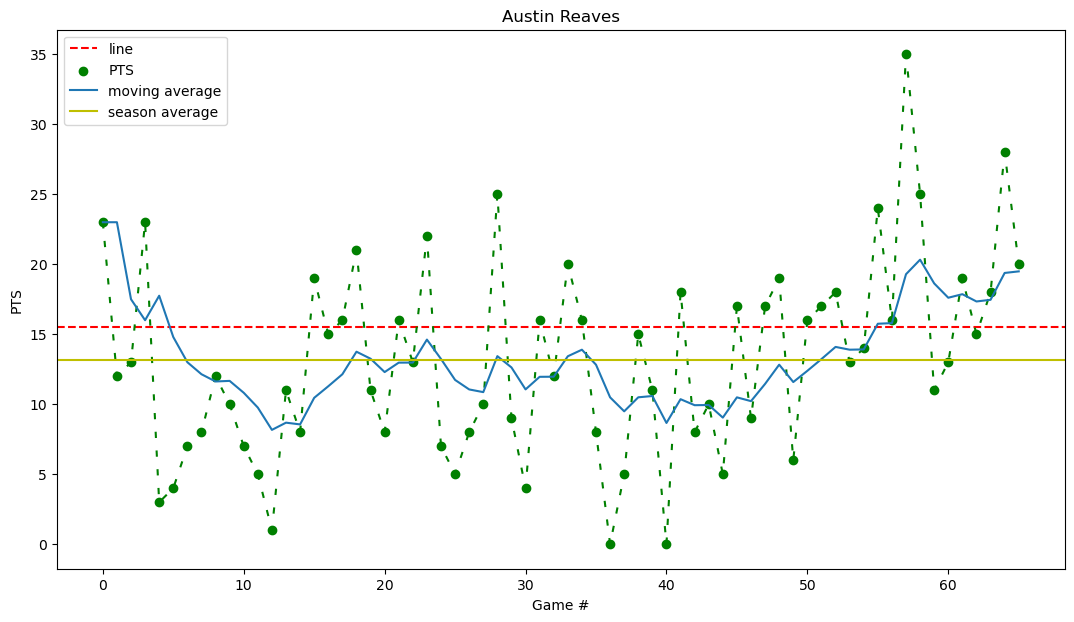

avg: 13.2


In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

graph_stat('Austin Reaves','PTS',10,pp_today)

In [ ]:
odd.columns = ['player', 'opp', 'home', 'stat', 'Season_avg', 'mov_avg', 'expected',
       'line', 'Last_10', 'season', 'blend', 'prob', 'Z']

In [ ]:
odd = odd[['player', 'opp', 'home', 'stat','expected','line', 'Last_10', 'season', 'prob']]

In [ ]:
lines.loc[lines.Player=='Austin Reaves']

AttributeError: 'DataFrame' object has no attribute 'Player'

In [ ]:
%%html
<style>
/*overwrite hard coded write background by vscode for ipywidges */
.cell-output-ipywidget-background {
   background-color: transparent !important;
}

/*set widget foreground text and color of interactive widget to vs dark theme color */
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [ ]:

from ipywidgets import interact, Dropdown
playerd = Dropdown(options = p_idx)
statd = Dropdown(options = s_idx)

@interact(print(''),player = playerd, stat = statd)
def print_city(player, stat):
    plt.style.use('dark_background')
    statd.options = lines.loc[lines['player']==player]['stat'] 
    graph_stat(player,stat,10,lines)
    display(odd.loc[odd['player']==player].sort_values(by='prob'))

interactive(children=(Dropdown(description='player', options=('Aaron Gordon', 'Anthony Edwards', 'Ausar Thomps…

In [ ]:
types = Dropdown(options = ['over','under'])
number = Dropdown(options = [10,20])
category = Dropdown(options = np.append('all',s_idx))

@interact(print(' '),types=types, number=number,category=category)
def print_city(types, number,category):
    pd.set_option('display.max_rows', number)
    pd.set_option('display.min_rows', number)
    if category == 'all':
        table = odd.sort_values(by='Prob')
    else:
        table = odd.loc[odd['Stat']==category].sort_values(by='Prob')
    if types == 'over':
        display(table.loc[table['Prob']>0.5].tail(number))
    if types == 'under':
        display(table.loc[table['Prob']<0.5].head(number))

interactive(children=(Dropdown(description='types', options=('over', 'under'), value='over'), Dropdown(descrip…

In [ ]:
odd

,Player,Opp,Home,Stat,expected,line,Last_10,Season,Prob
0,Jalen Brunson,CLE,1,AST,6.1,6.0,0.4,0.426,0.410
1,Jalen Brunson,CLE,1,PF,2.2,2.0,0.2,0.382,0.377
2,Jalen Brunson,CLE,1,PTS+TRB+AST,34.5,33.5,0.6,0.500,0.557
3,Jalen Brunson,CLE,1,PTS+TRB,28.4,27.5,0.4,0.456,0.555
4,Jalen Brunson,CLE,1,PTS+AST,31.6,29.5,0.6,0.529,0.636
...,...,...,...,...,...,...,...,...,...
308,Kevin Huerter,GSW,1,FT,0.8,0.5,0.5,0.541,0.551
309,Keegan Murray,GSW,1,FT,0.5,0.5,0.2,0.372,0.393
310,Draymond Green,SAC,1,FT,1.3,0.5,0.6,0.465,0.727
311,Kevon Looney,SAC,1,FT,1.6,0.5,0.8,0.575,0.798


In [ ]:
odd.to_csv('ontherun.csv')

In [ ]:
def check(lines):
    val = []
    everything = []
    err = 0
    date = lines['Date'][0]
    avail = data.loc[data['Date']< date]
    for i in range(len(lines)):
        if i%10 == 0:
            print(i)
        player = lines['Player'][i]
        date = lines['Date'][i]
        cat = lines['Stat'][i]
        line = lines['Line'][i]
        opp = lines['Team'][i]
        game  = get_game(player,date)
        expect = adjust(player,cat,opp,stats=avail)
        
        if game.empty:
            print('err',player)
            err += 1
        else:
            x = get_stat(player,cat,game)
            pred_diff = expect-line
            diff_real = x-line
            if np.sign(pred_diff) == np.sign(diff_real):
                val=1
            else:
                val=0
            season = float(print_prob(player,line,cat,stats=avail,prnt=False))
            l_10 = float(print_prob(player,line,cat,games=10,stats=avail,prnt=False))
            
            everything.append((player,opp,cat,expect,line,x[0],pred_diff,diff_real[0],val,l_10,season))
            
    x = np.array(everything)
    df = pd.DataFrame(x,columns=['Player','opp','Stat','pred','line','actual','pred_diff','diff_real','Win','l_10','season'])
    numeric = ['pred','line','actual','pred_diff','diff_real','Win','l_10','season']
    df[numeric]=df[numeric].astype(float)
    df['Prob']= 1- poisson.cdf(mu=df['pred'],k=df['line'])
    return df

In [ ]:
pp_yesterday = pp_yesterday.replace('Xavier Tillman','Xavier Tillman Sr.')

In [ ]:
pd.set_option('display.precision', 2)

df = check(pp_yesterday)
df

0
err LeBron James


KeyError: 'Dunks'

In [ ]:
end= df

In [ ]:
def results(final):
    bets = len(final)
    over_actual = len(final.loc[final['diff_real']>0])
    print(over_actual,bets)
    o_per = over_actual/bets
    under_actual = len(final.loc[final['diff_real']<0])
    u_per = under_actual/bets
    over_pred = len(final.loc[final['pred_diff']>0])
    o_wins = final.loc[final['pred_diff']>0]['Win'].sum()
    
    under_pred = len(final.loc[final['pred_diff']<0])
    u_wins = final.loc[final['pred_diff']<0]['Win'].sum()
    
    print(f'actual over:{over_actual}/{len(final)}, {100*o_per:.0f}%')
    print(f'actual under:{under_actual}/{len(final)}, {100*u_per:.0f}%')
    print('predicted over results',o_wins,over_pred, f'{o_wins/over_pred:.0%}')
    print('predicted under results:',u_wins,under_pred, f'{u_wins/under_pred:.0%}')
    print('overall results:',f'{(o_wins+u_wins)/bets:.0%}')
    return ((o_wins+u_wins)/bets)

In [ ]:
poiss_mid = end.loc[end['Prob']> 0.25]
poiss_low = poiss_mid.loc[poiss_mid['Prob']< 0.75]
results(poiss_mid)

In [ ]:
poiss_low = end.loc[end['Prob']< 0.3]
#poiss_low = poiss_low.loc[poiss_low['season']<0.5]
results(poiss_low)

In [ ]:
poiss_high = end.loc[end['Prob']> 0.7]
#poiss_high = poiss_high.loc[poiss_high['season']>0.5]
results(poiss_high)

In [ ]:
results(pd.concat((poiss_low,poiss_high)))

In [ ]:
parlay = pd.read_csv('parlaylines4_6')
parlay

In [ ]:
new_df = pd.merge(pp_today, dog_today,  how='left', left_on=['Player','Stat','Date'], right_on = ['Player','Stat','Date'],
                 suffixes=['_pp','_dog']) 
new_df

In [ ]:
new_df= new_df.dropna()
line_diff = new_df.loc[new_df['Line_pp'] != new_df['Line_dog']]
line_diff = line_diff.reset_index(drop=True)
line_diff

In [ ]:
new_df

In [ ]:
def best_diff_odds(lines):
    date = lines['Date'].iloc[0]
    home_teams = schedule.loc[schedule['Date']==date]['Home'].values
    player_lines = lines.iloc[:,0]
    avail = data.loc[data['Date']< date]
    player_idx = data['Player'].unique()
    vals = []
    for i in range(len(player_lines)):
        player = lines.iloc[i,0]
        
        if player in player_idx:
            cat = lines.iloc[i,3]
            opp = lines.iloc[i,1]
            if opp in home_teams:
                home = 0
            else:
                home = 1
            mov = dynamic(player, cat ,5,avail)
            series = np.array(get_stat(player,cat))
            line_pp = lines['Line_pp'][i]
            line_dog = lines['Line_dog'][i]
            season = print_prob(player,line_pp,cat,stats=avail,prnt=False)
            l_10 = print_prob(player,line_pp,cat,games=10,stats=avail,prnt=False)
            
            avg = np.mean(series)
            mov_avg = dynamic(player,cat)[-1]
            expected = adjust(player,cat,opp,avail)
            vals.append([player,opp,home,cat,round(avg,1),round(mov_avg,1),round(expected,1),line_pp,line_dog,l_10,season])
          
    odd = pd.DataFrame(vals,columns=['Player','Opp','Home','Stat','Season_avg','mov_avg','expected','line_pp','line_dog','Last_10','Season'])
    odd['blend'] = odd[['Last_10', 'Season']].mean(axis=1) 
    odd['Prob']= 1- poisson.cdf(mu=odd['expected'],k=odd['line_pp'])
            
    return odd

In [ ]:
pd.set_option('display.max_rows', 25)
pd.set_option('display.min_rows', 25)
diff = best_diff_odds(line_diff)

In [ ]:
diff['dog_Prob'] = 1- poisson.cdf(mu=diff['expected'],k=diff['line_dog'])
diff['Prob_diff'] = diff['Prob']-diff['dog_Prob']

In [ ]:
diff.sort_values(by='Prob_diff')

In [ ]:
dog_today.head(2)

In [ ]:
pp_under = diff.loc[(diff['line_pp'] > diff['line_dog']) & (diff['Prob'] < 0.5)]
pp_under.sort_values(by='Prob')

In [ ]:
pp_over = diff.loc[(diff['line_pp'] < diff['line_dog']) & (diff['Prob'] > 0.5)]
pp_over.sort_values(by='Prob')

In [ ]:
dog_under = diff.loc[(diff['line_dog'] > diff['line_pp']) & (diff['Prob'] < 0.5)]
dog_under.sort_values(by='dog_Prob')

In [ ]:
dog_over = diff.loc[(diff['line_dog'] < diff['line_pp']) & (diff['Prob'] > 0.5)]
dog_over.sort_values(by='dog_Prob')

In [ ]:
unabated = pd.read_csv('Lines/unabated', index_col=0)
unabated = unabated.sort_values(by='Prob')
fullpdf = pd.read_csv('Lines/fullpdf', index_col=0)
fullpdf = fullpdf.reset_index(drop=True)

In [ ]:
jak = fullpdf.loc[fullpdf.Player=='Jakob Poeltl']
jak.loc[jak.Stat=='TRB']

In [ ]:
odd.head(2)

In [ ]:
odd['market'] = None

In [ ]:
for i in range(len(odd)):
#    if i % 50 == 0:
#        print(i,'/',len(fullpdf))
    p = odd.Player[i]
    line = odd.line[i]
    stat = odd.Stat[i]
    find = fullpdf.loc[(fullpdf.Player == p)]
    find = find.loc[find.Stat==stat]
    find = find.loc[find.Line==line]
    if len(find) != 0:
        odd.market[i] = find.Prob.mean()

In [ ]:
test = odd.dropna()
test = test.sort_values(by='market')
test

In [ ]:
test.loc[test.Stat=='TRB']

In [ ]:
correlation = pd.read_csv('correlation')
correlation.head(5)

In [ ]:
sorted_odds = odd.sort_values(by='Prob').reset_index(drop=True)
pts = sorted_odds.loc[sorted_odds.Stat=='PTS']
pts

In [ ]:
pts.head(4)

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pts = sorted_odds.loc[sorted_odds.Stat=='PTS']
pts = pts.loc[pts.Prob >0.6].reset_index(drop=True)
players = pts.Player.unique()
for i in range(len(pts)): 
    p = pts.Player[i]
    guycorr = correlation.loc[correlation.P1 == p]
    guycorr = guycorr.loc[guycorr['P2'].isin(players)]
    guycorr = guycorr.loc[abs(guycorr.Corr) > 0.15]
    if guycorr.empty == False:
        print(p)
        display(guycorr)
        mainline = pts.iloc[i]
        for j in guycorr.P2:
            corrguy = pts.loc[pts.Player==j]
            mainline = pd.concat((corrguy.T,mainline.T),axis=1).T
        display(mainline)

In [ ]:
pts

In [ ]:
odd.to_csv('ontherun.csv')